# Example: Inferring causal structure using a pretrained AVICI model

Amortized variational inference for causal discovery (AVICI) allows inferring causal structure from data based on a **simulator** of the domain of interest.
By training a neural network to infer structure from the simulated data, it can acquire realistic inductive biases from prior knowledge that is hard to cast as score functions or conditional independence tests.


In this example, we **download a pretrained model checkpoint and perform predictions** for a simulated dataset. Inferring causal structure with a pretrained AVICI model takes only a few seconds since it amounts to one forward pass through the neural network.

Setup for Google Colab (Skip this if running locally).


In [7]:
%pip install --quiet avici

**Simulate some data:**

The function `simulate_data` accepts the following most important arguments:
- **d** (int) -- number of variables in the system
- **n** (int) -- number of observational data points to be sampled
- **n_interv** (int) -- number of interventional data points to be sampled
- **domain** (str) -- specifier of domain to be simulated.
  Current options: `lin-gauss`, `lin-gauss-heterosked`, `lin-laplace-cauchy`, `rff-gauss`, `rff-gauss-heterosked`, `rff-laplace-cauchy`, `gene-ecoli` (see `avici.config.examples`)

The function returns a 3-tuple of
- **g** -- adjacency matrix of shape `[d, d]` of causal graph
- **x** -- data matrix of shape `[n + n_interv, d]` containing `n + n_interv` observations of the `d` variables
- **interv** -- binary matrix of shape `[n + n_interv, d]` encoding which nodes were intervened upon (`None` if `n_interv=0`)

In [ ]:
import numpy as np
import pandas as pd
import avici
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
data = pd.read_csv('trip_test.csv')
x = data.to_numpy()

# 获取列名
columns = data.columns

# 加载预训练模型
model = avici.load_pretrained(download="scm-v0")

# 设置批次大小
batch_size = 10000

# 初始化因果结构概率矩阵
g_probs = []

# 分批处理数据
for i in range(0, len(x), batch_size):
    batch = x[i:i+batch_size]
    g_prob = model(x=batch)
    g_probs.append(g_prob)
    break

# 合并所有批次的结果
g_prob = np.concatenate(g_probs)

# 将概率矩阵转换为有向图
threshold = 0.5
g = nx.DiGraph()
g.add_nodes_from(columns)
for i in range(len(columns)):
    for j in range(len(columns)):
        if g_prob[i, j] > threshold:
            g.add_edge(columns[i], columns[j])



Using default cache_path: `/content/cache`


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Predicted Causal Structure:
Initial SOC -> Hour of departure
Final SOC -> Hour of departure
Doors open time -> Door1 open time
Doors open time -> Door2 open time
Travel distance -> Clustering travel time
Departure lat -> Arrival lat
Arrival lng -> Outside temp
Hour of departure -> Outside temp
Average speed -> Clustering travel time
Average speed -> Clustering idle percentage
Min speed -> SOC diff
Std of speed -> Clustering idle percentage
Std of acc -> Max acc
Std of acc -> Clustering max acc
Average dec -> Std of dec
Average dec -> Clustering average dec
Average dec -> Clustering std of dec
Std of dec -> Clustering std of dec
Num of brake pedal -> Num of sharp acc pedal
Clustering travel distance -> Clustering travel time
Clustering average speed -> Clustering travel time
Clustering average speed -> Clustering idle percentage
Clustering average travel speed -> Average speed
Clustering average travel speed -> Num of stop
Clustering average travel speed -> Clustering average speed
Clus

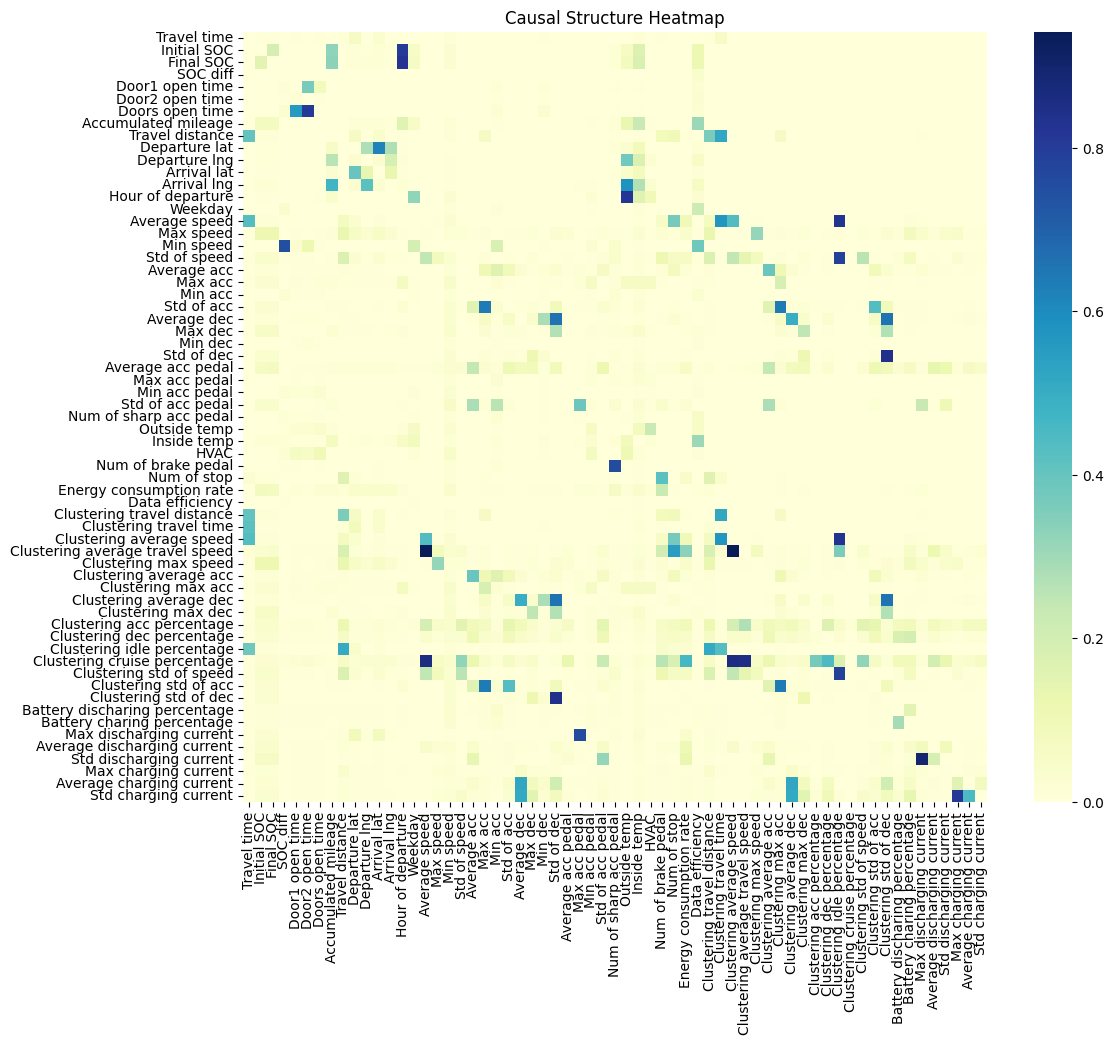

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 输出预测的因果结构
print("Predicted Causal Structure:")
for edge in g.edges():
    print(f"{edge[0]} -> {edge[1]}")
# 可视化因果结构热力图
plt.figure(figsize=(12, 10))
sns.heatmap(g_prob, fmt=".2f", cmap="YlGnBu", xticklabels=columns, yticklabels=columns)
plt.title("Causal Structure Heatmap")
plt.show()

**Download and initialize a pretrained model:**

We currently provide the following models checkpoints,
which can be specified by the `download` argument:

- `scm-v0` (**default**): linear and nonlinear SCM data, broad graph and noise distributions
- `neurips-linear`: SCM data with linear causal mechanisms
- `neurips-rff`: SCM data with nonlinear causal mechanisms drawn
from GPs with squared-exponential kernel
(defined via random Fourier features)
- `neurips-grn`: Synthetic scRNA-seq gene expression data using the SERGIO
[simulator](https://github.com/PayamDiba/SERGIO) by
[Dibaeinia and Sinha, (2020)](https://www.cell.com/cell-systems/pdf/S2405-4712(20)30287-8.pdf)


**Predict the causal structure:**

Calling `model` as obtained from `avici.load_pretrained` predicts the `[d, d]` matrix of probabilities for each possible edge in the causal graph and accepts the following arguments:

- **x** (ndarray) -- real-valued data matrix of shape `[n, d]`
- **interv** (ndarray, optional) --  binary matrix of the same shape as **x** with **interv[i,j] = 1** iff node **j** was intervened upon in observation **i**. (Default is `None`)
- **return_probs** (bool, optional) -- whether to return probability estimates for each edge. `False` simply clips the predictions to 0 and 1 using a decision threshold of 0.5. (Default is `True` as the computational cost is the same.)


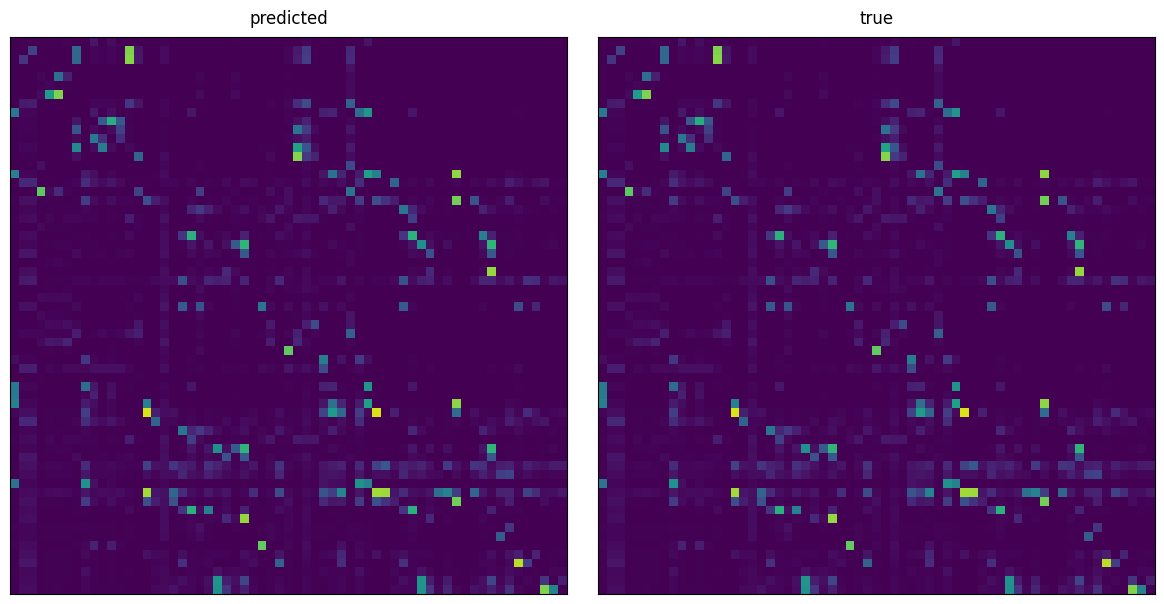

In [15]:
from avici.metrics import shd, classification_metrics, threshold_metrics

# visualize predictions and compute metrics
avici.visualize(g_prob,true=g_prob,size=0.75)
